## DoubleDQN with Prioritized Replay (PER) and Dueling Network Architecture

### Import Required Libraries

In [2]:
import math, random, time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


device = "cuda" if torch.cuda.is_available() else "cpu"
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).to(device)

from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

### Build Prioritized Memory Replay Buffer

In [5]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)


### Build Lambda Functions for Epsilon Greedy Strategy and Annealing of PER's beta parameter 

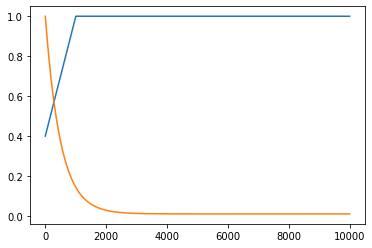

In [6]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

plt.plot([beta_by_frame(i) for i in range(10000)])

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(10000)])

### Build Classes for DQN and Dueling DQN (Linear)

In [23]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),frame_idx
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action
    
class DuelingCnnDQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DuelingCnnDQN, self).__init__()
        
        
        self.input_shape = input_shape
        self.num_actions = num_outputs
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

### Build Functions for computing the temporal difference loss.

In [8]:
   
def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    weights    = Variable(torch.FloatTensor(weights))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = F.smooth_l1_loss(q_value, expected_q_value.detach(), reduction='none') * weights
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()
    
    return loss

def compute_td_loss_double_huber(batch_size, beta):
    """
    For double DQN we use the policy network for estimating the  current and next q values
    whilst using the target network also to estimate the next q values.
    The estimates for the next q values from the policy network are then used to pick the next action whilst the
    estimate from the policy nextwork is then used to rate how good that action was.
    """
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    weights    = Variable(torch.FloatTensor(weights))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = F.smooth_l1_loss(q_value, expected_q_value.detach(), reduction='none') * weights
    prios = loss + 1e-5
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss


### Helper Functions for plotting and model updates

In [26]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    ax2 = plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    ax1.set_ylim(0,100)
    ax2.set_ylim(0,100)
    plt.show()
    
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

### Train DQN and save model after various training periods.

In [ ]:

#Hyperparameters
num_frames = 1000000
buffer_size = 400000
batch_size = 32
gamma      = 0.99
learning_rate = 0.001 
update_targets = 1000
replay_initial = 10000

#Plotting Controls
plot_frequency = 2500
render = False

#initialize counters/trackers etc
losses = []
all_rewards = []
duration = []
episode_reward = 0
timer = time.time()

#Build Env
env_id = "PongNoFrameskip-v0"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

#Build Networks
current_model = DuelingCnnDQN(env.observation_space.shape, env.action_space.n).to(device)
target_model  = DuelingCnnDQN(env.observation_space.shape, env.action_space.n).to(device)
target_model.eval()    

#Align Weights in target network to match the policy network
update_target(current_model, target_model)

#Build Optimizer
optimizer = optim.Adam(current_model.parameters(), lr=learning_rate)

#Build Replay Buffer (Prioritized)
replay_buffer  = NaivePrioritizedBuffer(buffer_size)

#Start Training
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    
    if render:
        env.render()
    
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        duration.append(time.time() - timer)
        timer = time.time()
        
    if len(replay_buffer) > replay_initial:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss_double_huber(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % plot_frequency == 0:
        plot(frame_idx, all_rewards, losses)
        print("Average Episode Duration: %s" % np.mean(duration[-10:]))
        
    if frame_idx % update_targets == 0:
        update_target(current_model, target_model)